In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import tensorflow
import os
from sklearn.preprocessing import LabelEncoder
# 设置中文字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [2]:
data = pd.read_csv(
                    "./pre_data/gy_link_travel_time_part1/gy_link_travel_time_part1.txt",
                    delimiter=';',
                    dtype={'link_ID':object}
)
link_info = pd.read_csv(
                    "./pre_data/gy_link_info.txt",
                    delimiter=';',
                    dtype={'link_ID':object}
)
link_ids = np.sort(link_info['link_ID'].unique())
link_ids

array(['3377906280028510514', '3377906280395510514',
       '3377906281518510514', '3377906281774510514',
       '3377906282328510514', '3377906282418510514',
       '3377906283328510514', '3377906284028510514',
       '3377906284395510514', '3377906285434510514',
       '3377906285934510514', '3377906286918510514',
       '3377906287674510514', '3377906287886510514',
       '3377906287934510514', '3377906288228510514',
       '3377906289044510514', '3377906289228510514',
       '3377906289434510514', '3377906289674510514',
       '4377906280141600514', '4377906280163800514',
       '4377906280234600514', '4377906280241600514',
       '4377906280329500514', '4377906280334600514',
       '4377906280344800514', '4377906280763800514',
       '4377906280784800514', '4377906280815800514',
       '4377906280863800514', '4377906280913600514',
       '4377906280969500514', '4377906281041600514',
       '4377906281141600514', '4377906281234600514',
       '4377906281241600514', '437790628174160

In [4]:
# print(np.sort(data['date'].unique())[0])
# print(np.sort(data['date'].unique())[-1])

In [3]:
# 处理时间列
data['start_time'] =pd.to_datetime(data['time_interval'].str.split(',').str[0].str.strip('['))
data.drop(columns=['time_interval','date'],inplace=True)
data.head()

,link_ID,travel_time,start_time
0,9377906285566510514,17.6,2016-05-21 23:20:00
1,3377906288228510514,3.5,2016-05-21 18:46:00
2,3377906284395510514,10.0,2016-05-21 07:06:00
3,4377906284959500514,3.5,2016-05-21 14:34:00
4,9377906282776510514,1.5,2016-05-21 05:04:00


In [5]:
data_sorted = data.sort_values(by=['link_ID','start_time'],ascending=[True, True])
data_sorted = data_sorted.reset_index(drop=True)

In [6]:
# 构建时间序列数据
date_range = pd.date_range("2016-03-01 00:00:00","2016-06-30 23:58:00",freq='2min')
date_range[:5]

DatetimeIndex(['2016-03-01 00:00:00', '2016-03-01 00:02:00',
               '2016-03-01 00:04:00', '2016-03-01 00:06:00',
               '2016-03-01 00:08:00'],
              dtype='datetime64[ns]', freq='2T')

In [8]:
new_index = pd.MultiIndex.from_product([link_ids,date_range],
                                      names=['link_ID','start_time'])
new_df = pd.DataFrame(index=new_index).reset_index()
new_df.head()

,link_ID,start_time
0,3377906280028510514,2016-03-01 00:00:00
1,3377906280028510514,2016-03-01 00:02:00
2,3377906280028510514,2016-03-01 00:04:00
3,3377906280028510514,2016-03-01 00:06:00
4,3377906280028510514,2016-03-01 00:08:00


In [9]:
df_merge = pd.merge(new_df,data_sorted,on=['link_ID','start_time'],how='left')

In [10]:
df_merge.head()

,link_ID,start_time,travel_time
0,3377906280028510514,2016-03-01 00:00:00,4.6
1,3377906280028510514,2016-03-01 00:02:00,NaN
2,3377906280028510514,2016-03-01 00:04:00,NaN
3,3377906280028510514,2016-03-01 00:06:00,10.5
4,3377906280028510514,2016-03-01 00:08:00,10.5


In [11]:
nan_count = df_merge['travel_time'].isna().sum()
val_count = len(df_merge['travel_time'])
nan_count/val_count

# df_linear = df_merge['travel_time'].interpolate(method='linear', inplace=True)
# df_linear.head()

0.33915797317436663

In [12]:
df_merge['travel_time'].interpolate(method='linear', inplace=True)

In [13]:
df_merge["Year"]= df_merge['start_time'].dt.year
df_merge["Month"]= df_merge['start_time'].dt.month
df_merge["Date_no"]= df_merge['start_time'].dt.day
df_merge["Hour"]= df_merge['start_time'].dt.hour
df_merge["Day"]= df_merge.start_time.dt.strftime("%A")

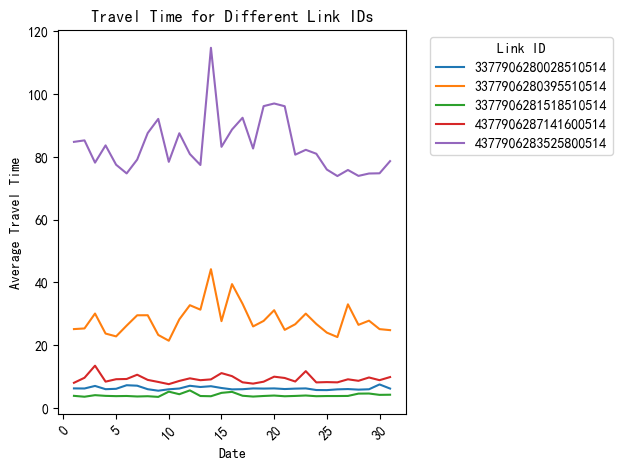

In [14]:
df_day = df_merge.groupby(["link_ID","Date_no"]).agg({"travel_time":"mean"}).reset_index()
plot_ids = ['3377906280028510514', '3377906280395510514','3377906281518510514','4377906287141600514','4377906283525800514']  # 选择要进行可视化的id
for link_id in plot_ids:
    df_filtered = df_day[df_day['link_ID'] == link_id]
    plt.plot(df_filtered['Date_no'], df_filtered['travel_time'], label=link_id)
plt.legend(title='Link ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Travel Time for Different Link IDs')
plt.xlabel('Date')
plt.ylabel('Average Travel Time')
plt.xticks(rotation=45)  
plt.tight_layout()  

# 一个月之内，道路的通行时间

In [17]:
filtered_df = df_merge[df_merge['link_ID'].isin(plot_ids)]
filtered_df['link_ID'].unique()

array(['3377906280028510514', '3377906280395510514',
       '3377906281518510514', '4377906283525800514',
       '4377906287141600514'], dtype=object)

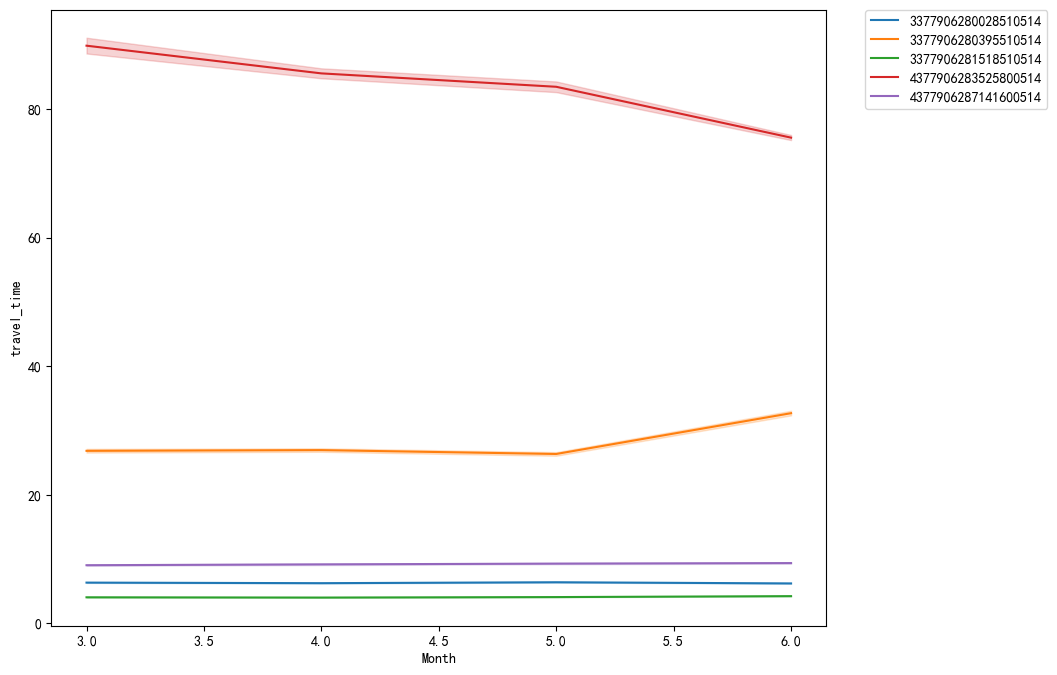

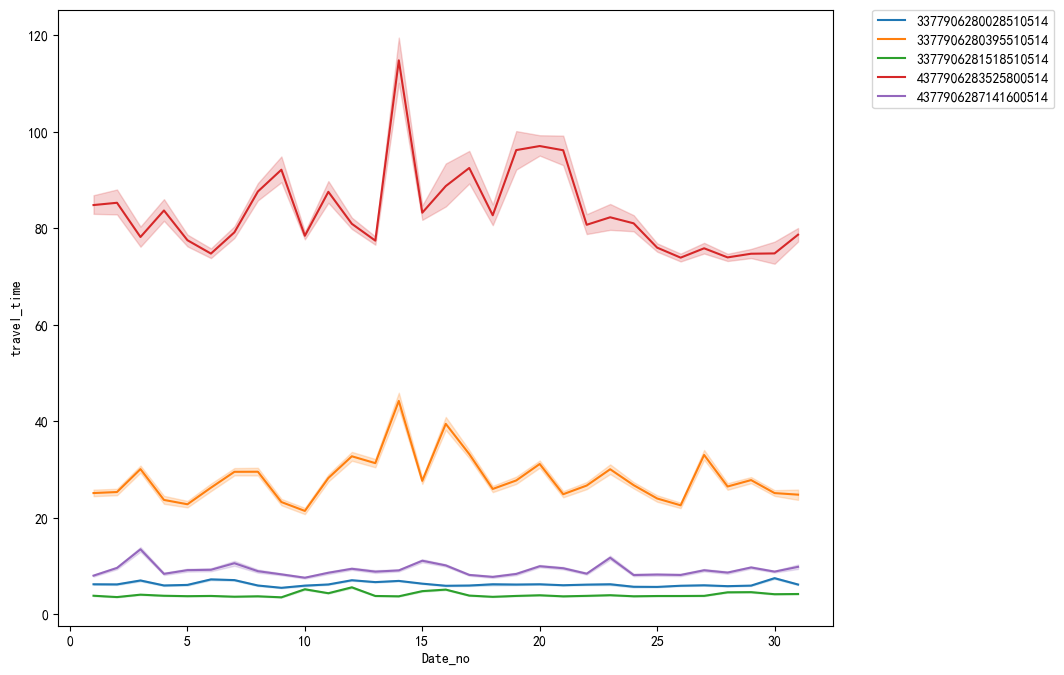

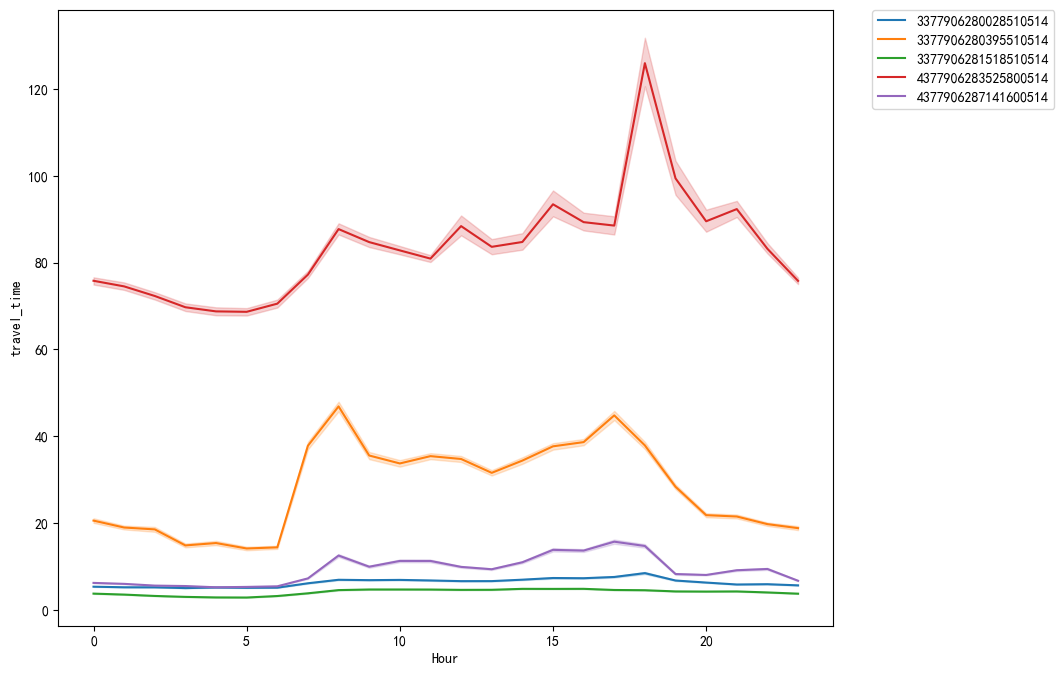

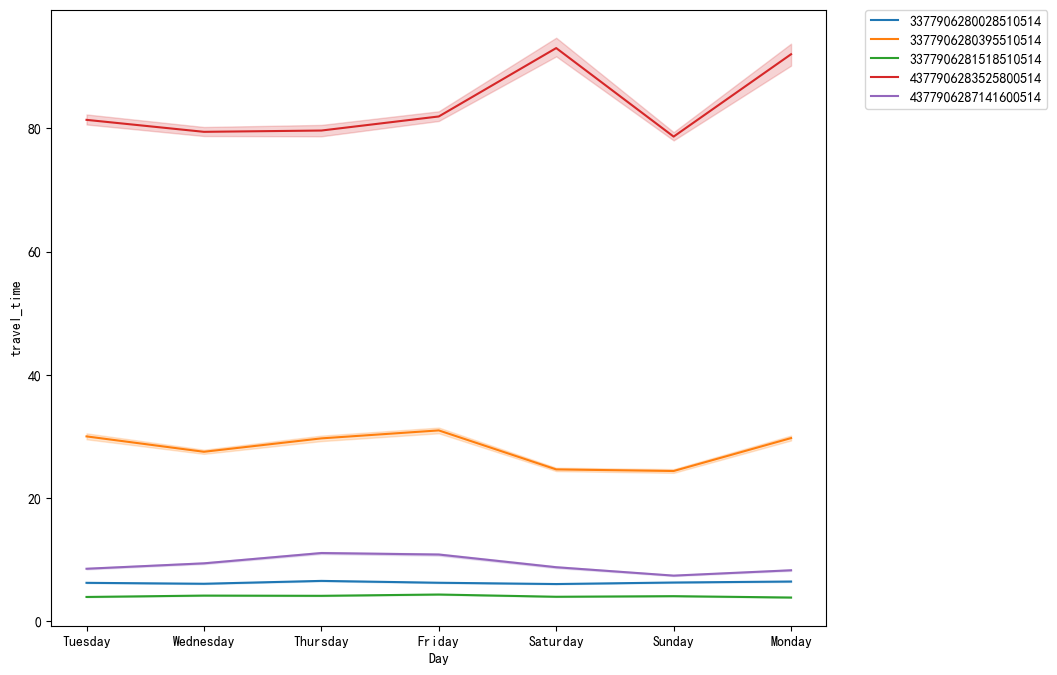

In [18]:
new_features = ["Month", "Date_no", "Hour", "Day"]
for i in new_features:
    plt.figure(figsize=(10,8))
    ax=sns.lineplot(x=filtered_df[i],y="travel_time",data=filtered_df,hue='link_ID')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

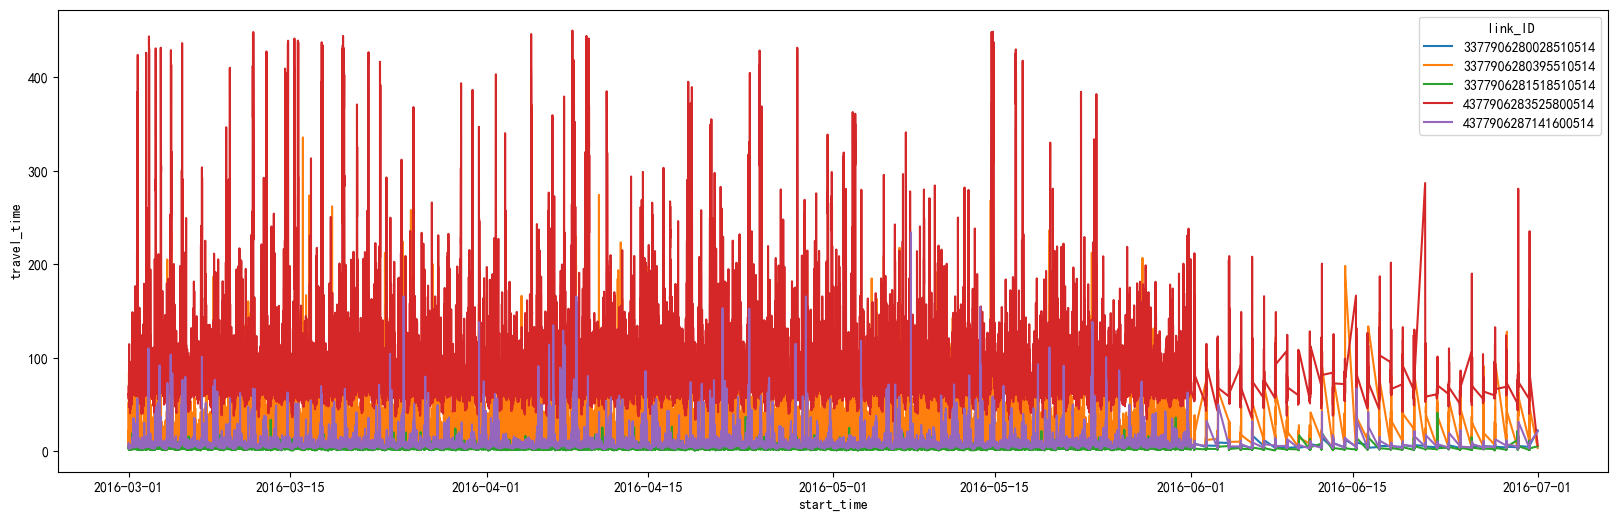

In [22]:
plt.figure(figsize=(20,6))
min_value = 0
max_value =450
filtered_df_0 = filtered_df[(filtered_df['travel_time'] >= min_value) & (filtered_df['travel_time'] <= max_value)]
ax=sns.lineplot(x=filtered_df_0['start_time'],y="travel_time",data=filtered_df, hue="link_ID")

In [23]:
data_info = pd.merge(df_merge,link_info,on=['link_ID'],how='left')
data_info.head()

,link_ID,start_time,travel_time,Year,Month,Date_no,Hour,Day,length,width,link_class
0,3377906280028510514,2016-03-01 00:00:00,4.600000,2016,3,1,0,Tuesday,48,3,1
1,3377906280028510514,2016-03-01 00:02:00,6.566667,2016,3,1,0,Tuesday,48,3,1
2,3377906280028510514,2016-03-01 00:04:00,8.533333,2016,3,1,0,Tuesday,48,3,1
3,3377906280028510514,2016-03-01 00:06:00,10.500000,2016,3,1,0,Tuesday,48,3,1
4,3377906280028510514,2016-03-01 00:08:00,10.500000,2016,3,1,0,Tuesday,48,3,1


<BarContainer object of 7 artists>

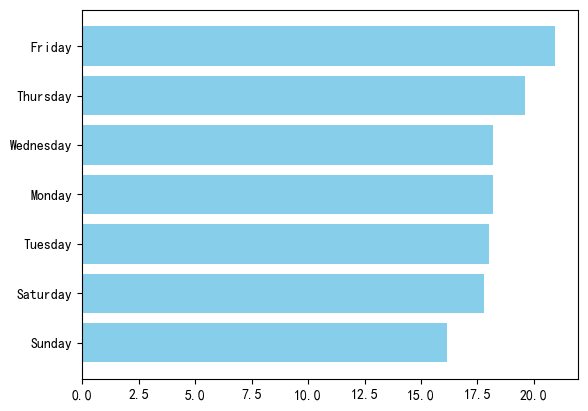

In [24]:
df_day = data_info.groupby("Day").agg({"travel_time":"mean"}).reset_index().sort_values(by="travel_time",ascending=False)
x = df_day['Day'].to_list()
x.reverse()
y = df_day['travel_time'].to_list()
y.reverse()
plt.barh(x,y, color='skyblue')
# 所有道路一周的平均通行时间排序

Text(0, 0.5, 'Time Interval')

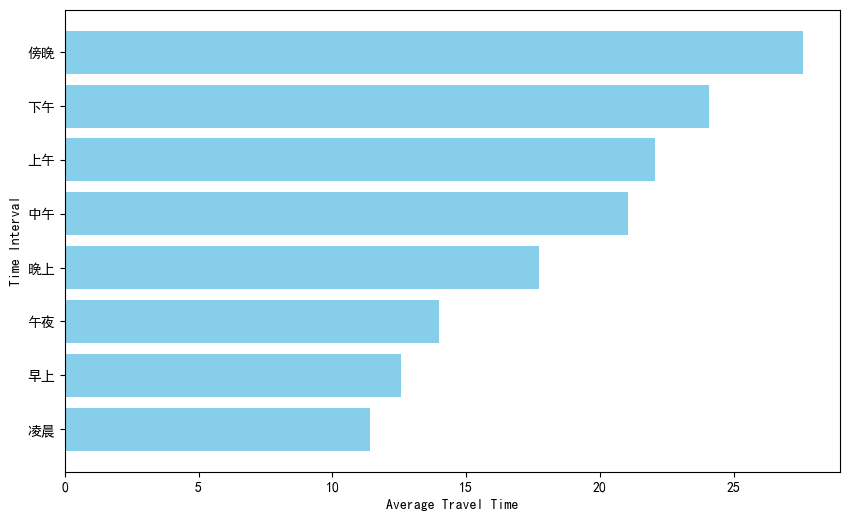

In [25]:
h = {}
h["凌晨"] = data_info[(data_info['Hour']>=1) & (data_info['Hour']<5)]['travel_time'].mean()
h["早上"] = data_info[(data_info['Hour']>=5) & (data_info['Hour']<8)]['travel_time'].mean()
h["上午"] = data_info[(data_info['Hour']>=8) & (data_info['Hour']<11)]['travel_time'].mean()
h["中午"] = data_info[(data_info['Hour']>=11) & (data_info['Hour']<13)]['travel_time'].mean()
h["下午"] = data_info[(data_info['Hour']>=13) & (data_info['Hour']<17)]['travel_time'].mean()
h["傍晚"] = data_info[(data_info['Hour']>=17) & (data_info['Hour']<19)]['travel_time'].mean()
h["晚上"] = data_info[(data_info['Hour']>=19) & (data_info['Hour']<23)]['travel_time'].mean()
h["午夜"] = data_info[(data_info['Hour']==23) | (data_info['Hour']==0)]['travel_time'].mean()
sorted_h = dict(sorted(h.items(), key=lambda item: item[1], reverse=False))

plt.figure(figsize=(10, 6))
plt.barh(list(sorted_h.keys()),sorted_h.values(), color='skyblue')
plt.xlabel('Average Travel Time')
plt.ylabel('Time Interval')

# 一天内通行时间排序

In [26]:
link_top = pd.read_csv(
                    "./pre_data/gy_link_top.txt",
                    delimiter=';',
                    dtype={'link_ID':object,'in_links':object,'out_links':object}
)
link_top['in_links'] = link_top['in_links'].fillna('')
link_top['out_links'] = link_top['out_links'].fillna('')
link_top.head()

,link_ID,in_links,out_links
0,4377906289869500514,4377906285525800514,4377906281969500514
1,4377906284594800514,4377906284514600514,4377906285594800514
2,4377906289425800514,,4377906284653600514
3,4377906284525800514,4377906281234600514,4377906280334600514
4,4377906284422600514,3377906289434510514#4377906287959500514,4377906283422600514


In [27]:
link_top_tmp = link_top.copy()
link_top_tmp['in_links_count'] = link_top_tmp['in_links'].apply(lambda x: len(x.split('#')) if x else 0)
link_top_tmp['out_links_count'] = link_top_tmp['out_links'].apply(lambda x: len(x.split('#')) if x else 0)

In [28]:
link_top_tmp['link_density'] = link_top_tmp['in_links_count'] + link_top_tmp['out_links_count']
link_top_tmp['in_out_ratio'] = link_top_tmp.apply(lambda x: x['in_links_count'] / x['out_links_count'] if x['out_links_count'] > 0 else 0, axis=1)
link_top_tmp = link_top_tmp.drop(columns=['in_links','out_links'])

In [29]:
link_top_tmp.head()

,link_ID,in_links_count,out_links_count,link_density,in_out_ratio
0,4377906289869500514,1,1,2,1.0
1,4377906284594800514,1,1,2,1.0
2,4377906289425800514,0,1,1,0.0
3,4377906284525800514,1,1,2,1.0
4,4377906284422600514,2,1,3,2.0


In [30]:
data_info_merge = pd.merge(data_info,link_top_tmp,on=['link_ID'],how='left')
data_info_merge['length_width_ratio'] = data_info_merge.apply(lambda x: x['length'] * x['width'] if x['width'] > 0 else 0, axis=1)

In [22]:
data_info_merge.to_csv('./data/dataset1.txt',sep=';',index=False)

<Axes: >

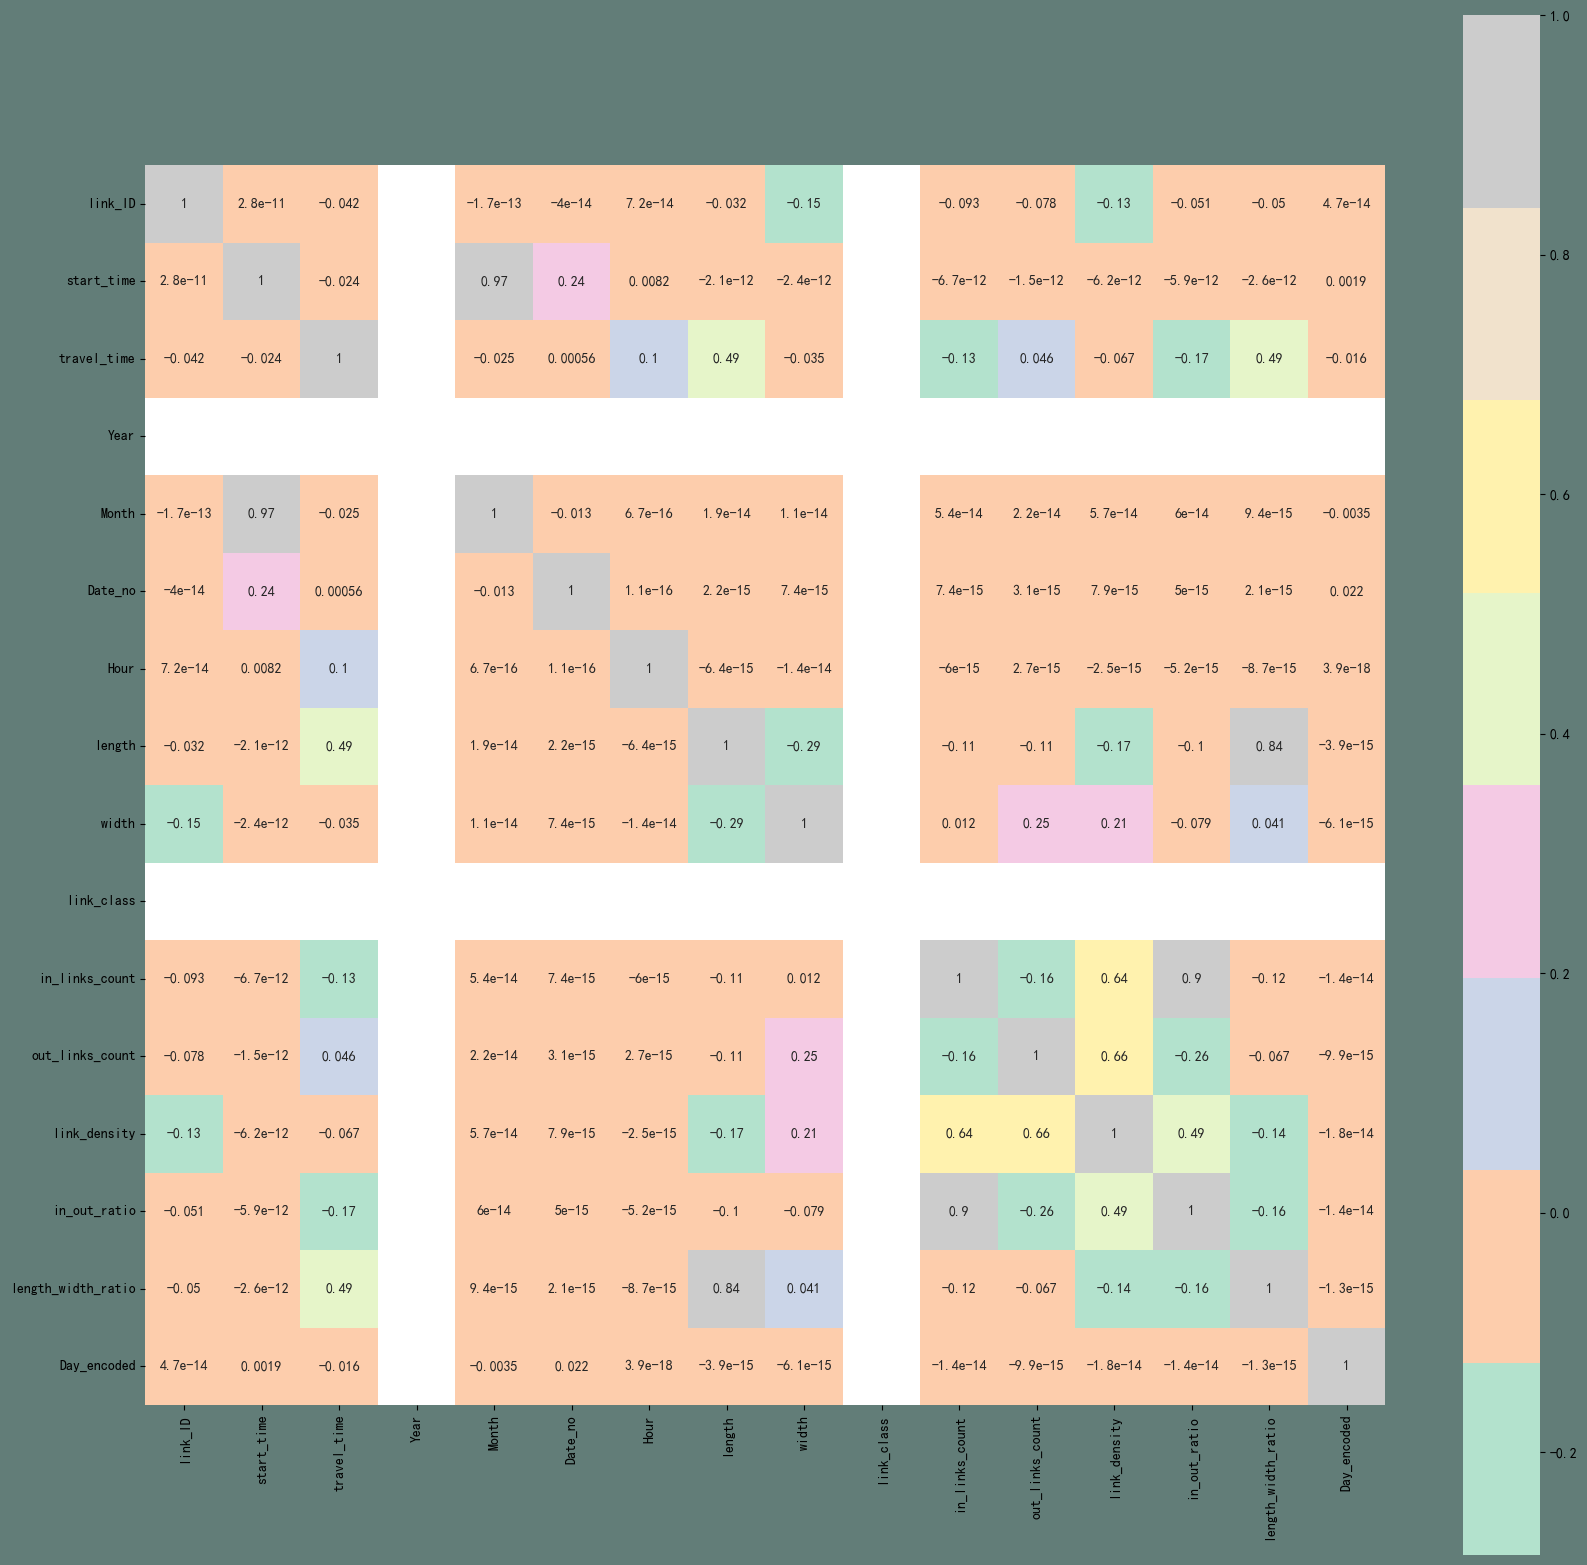

In [31]:
data_info_tmp = data_info_merge.copy()
le = LabelEncoder()
data_info_tmp['Day_encoded'] = le.fit_transform(data_info['Day'])
data_info_tmp= data_info_tmp.drop(columns=['Day'])
corrmat = data_info_tmp.corr()
plt.subplots(figsize=(20,20),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True)

In [32]:
data_info_tmp = data_info_tmp.drop(columns=['Year','link_class'])

In [33]:
data_info_tmp.head()

,link_ID,start_time,travel_time,Month,Date_no,Hour,length,width,in_links_count,out_links_count,link_density,in_out_ratio,length_width_ratio,Day_encoded
0,3377906280028510514,2016-03-01 00:00:00,4.600000,3,1,0,48,3,1,1,2,1.0,144,5
1,3377906280028510514,2016-03-01 00:02:00,6.566667,3,1,0,48,3,1,1,2,1.0,144,5
2,3377906280028510514,2016-03-01 00:04:00,8.533333,3,1,0,48,3,1,1,2,1.0,144,5
3,3377906280028510514,2016-03-01 00:06:00,10.500000,3,1,0,48,3,1,1,2,1.0,144,5
4,3377906280028510514,2016-03-01 00:08:00,10.500000,3,1,0,48,3,1,1,2,1.0,144,5


In [34]:
df_ID = data_info_tmp.groupby("link_ID").agg({"travel_time":"mean"}).reset_index().sort_values(by="travel_time",ascending=False)

<BarContainer object of 10 artists>

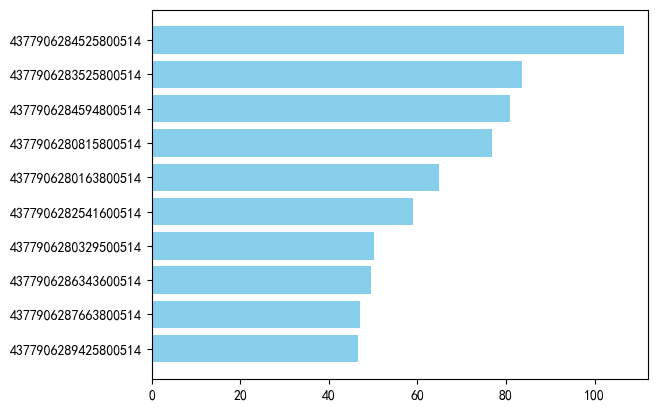

In [35]:
x = df_ID.head(10)['link_ID'].to_list()
x.reverse()
y = df_ID.head(10)['travel_time'].to_list()
y.reverse()
plt.barh(x,y, color='skyblue')
# 道路平均通行时间排序